In [1]:
!pip install evaluate
!pip install sacremoses

!pip install -U portalocker
!python -m spacy download en_core_web_sm  # English model
!python -m spacy download de_core_news_sm  # German model

!pip install torch==2.0.1 torchtext==0.15.2

import torch
import torchtext

print(torch.__version__)
print(torchtext.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 27.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import urllib.request
import tarfile
from torch.utils.data import Subset
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

In [3]:
os.environ["WANDB_DISABLED"] = "true"

# Define URL and target filenames
url = "https://www.statmt.org/europarl/v7/de-en.tgz"
filename = "de-en.tgz"
extract_path = "europarl_data"

# Create directory for extraction
os.makedirs(extract_path, exist_ok=True)

# Download only if the file isn't already present
if not os.path.exists(filename):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete.")

# Extract only if not already extracted
if not os.path.exists(os.path.join(extract_path, "europarl-v7.de-en.en")):
    print("Extracting dataset...")
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# File paths for the English and German sentences
en_file = os.path.join(extract_path, "europarl-v7.de-en.en")
de_file = os.path.join(extract_path, "europarl-v7.de-en.de")



# Custom Dataset class for reading parallel text files
class TranslationDataset(Dataset):
    def __init__(self, en_file, de_file):
        """
        Args:
            en_file: Path to the English sentences file (one sentence per line).
            de_file: Path to the French/German sentences file (one sentence per line).
        """
        # Read the English and german files
        with open(en_file, 'r', encoding='utf-8') as f:
            self.en_sentences = [line.strip() for line in f.readlines()]

        with open(de_file, 'r', encoding='utf-8') as f:
            self.de_sentences = [line.strip() for line in f.readlines()]

        assert len(self.en_sentences) == len(self.de_sentences), "Mismatch in sentence count!"

    def __len__(self):
        return len(self.en_sentences)

    def __getitem__(self, idx):
        """
        Returns the pair of English and German sentences at the given index.
        """
        return self.en_sentences[idx], self.de_sentences[idx]


full_dataset = TranslationDataset(en_file, de_file)
train_indices, val_indices = train_test_split(list(range(len(full_dataset))), test_size=0.1, random_state=42)

# train_dataset = Subset(full_dataset, train_indices)
# valid_dataset = Subset(full_dataset, val_indices)

train_dataset_1 = Subset(full_dataset, train_indices) #CHANGE!!!
valid_dataset_1 = Subset(full_dataset, val_indices) #CHANGE!!!
print(len(train_dataset_1))
print(len(valid_dataset_1))

# Initialize the dataset
train_dataset = Subset(train_dataset_1, list(range(9000)))  #CHANGE!!!!
valid_dataset = Subset(valid_dataset_1, list(range(1000))) #CHANGE!!!!!

print("dataset looks like; ",train_dataset[0])

Download complete.
Extracting dataset...
Extraction complete.
1728188
192021
dataset looks like;  ('This amendment raises a new issue on evidence that has recently come to light.', 'Dieser Änderungsantrag wirft, ausgehend von jüngsten Erkenntnissen, ein neues Problem auf.')


In [4]:
# Initialize tokenizers for both English and German
token_transform = {}
token_transform['en'] = get_tokenizer('spacy', language='en_core_web_sm')  # English tokenizer
token_transform['de'] = get_tokenizer('spacy', language='de_core_news_sm')  # German tokenizer

# Helper function to yield list of tokens for a given language
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {'en': 0, 'de': 1}
    for data_sample in data_iter:
        sentence = data_sample[language_index[language]]  # a sentence
        yield token_transform[language](sentence)  # Tokenize and yield list of tokens


# Define special symbols and indicis
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3


vocab_transform = {}
for ln in ['en', 'de']:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )
    vocab_transform[ln].set_default_index(UNK_IDX)

In [5]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),  # add BOS token at the start
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))  # add EOS token at the end


# source and target language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in ['en', 'de']:
    text_transform[ln] = sequential_transforms(token_transform[ln],  # tokenize text
                                               vocab_transform[ln],  # map tokens to indices
                                               tensor_transform)  # add BOS/EOS and create tensor




# collate function to prepare batches
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # apply the text transformation (tokenization and numericalization)
        src_batch.append(text_transform['en'](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform['de'](tgt_sample.rstrip("\n")))

    # pad the source and target sequences to the max length in the batch
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True).long()
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True).long()

    return src_batch, tgt_batch

In [6]:
# hyper parameters
SRC_VOCAB_SIZE = len(vocab_transform['en'])
TGT_VOCAB_SIZE = len(vocab_transform['de'])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 20



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [7]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt_input):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt_input.shape[1]

    # tgt_mask must be [tgt_seq_len, tgt_seq_len]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # src_mask is usually all-zeros (no lookahead mask needed)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)  # shape: [batch_size, src_seq_len]
    tgt_padding_mask = (tgt_input == PAD_IDX)  # shape: [batch_size, tgt_seq_len]

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute positional encodings once in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)

    def forward(self, x):
        return self.embedding(x)


class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()

        self.transformer = nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, tgt_mask: Tensor,
                src_padding_mask: Tensor, tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [9]:
# Initialize the model
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)

In [10]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys



def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = torch.tensor(text_transform['en'](src_sentence), dtype=torch.long).view(1, -1).to(DEVICE)
    num_tokens = src.shape[1]
    src_mask = torch.zeros(num_tokens, num_tokens, device=DEVICE).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    # Convert tensor to Python list directly instead of using numpy
    tgt_tokens_list = tgt_tokens.cpu().tolist()  # Converts tensor to list
    translated = vocab_transform['de'].lookup_tokens(tgt_tokens_list)
    translated = [token for token in translated if token not in ("<bos>", "<eos>", "<pad>", "<unk>")]

    return " ".join(translated)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
# Training loop
def train_epoch(model, optimizer, loss_fn, dataloader):
    print('Training')
    model.train()
    total_loss = 0

    for src, tgt in tqdm(dataloader, total=len(list(dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(list(dataloader))

val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
# Evaluation loop
def evaluate(model, loss_fn, dataloader):
    print('Validating')
    model.eval()
    total_loss = 0
    total_bleu = 0
    count = 0
    smoothie = SmoothingFunction().method4

    for src, tgt in tqdm(dataloader, total=len(list(dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        total_loss += loss.item()

        # BLEU
        for i in range(src.size(0)):
            src_tokens = vocab_transform['en'].lookup_tokens(src[i].cpu().tolist())
            src_text = " ".join([t for t in src_tokens if t not in ("<pad>", "<bos>", "<eos>", "<unk>")])

            tgt_tokens = vocab_transform['de'].lookup_tokens(tgt[i].cpu().tolist())
            ref_tokens = [t for t in tgt_tokens if t not in ("<pad>", "<bos>", "<eos>", "<unk>")]

            pred_text = translate(model, src_text)
            pred_tokens = pred_text.split()

            if pred_tokens and ref_tokens:
                total_bleu += sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
                count += 1

    avg_loss = total_loss / len(list(dataloader))
    avg_bleu = total_bleu / count if count > 0 else 0.0
    return avg_loss, avg_bleu

In [11]:
train_losses = []
val_losses = []
val_bleus = []


for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, optimizer, loss_fn, train_dataloader)
    val_loss, val_bleu = evaluate(model, loss_fn, val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | BLEU: {val_bleu:.4f}")

Training


  0%|          | 0/563 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/63 [00:00<?, ?it/s]

<ipython-input-10-5984e984d848>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(text_transform['en'](src_sentence), dtype=torch.long).view(1, -1).to(DEVICE)


Epoch 1/20 | Train Loss: 7.2347 | Val Loss: 6.6206 | BLEU: 0.0149
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 6.3709 | Val Loss: 6.3671 | BLEU: 0.0222
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 6.1055 | Val Loss: 6.1842 | BLEU: 0.0261
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 5.8970 | Val Loss: 6.0602 | BLEU: 0.0289
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 5.7267 | Val Loss: 5.9619 | BLEU: 0.0307
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 5.5801 | Val Loss: 5.8840 | BLEU: 0.0323
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 5.4510 | Val Loss: 5.8201 | BLEU: 0.0356
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 5.3336 | Val Loss: 5.7754 | BLEU: 0.0368
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 5.2237 | Val Loss: 5.7382 | BLEU: 0.0395
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 5.1149 | Val Loss: 5.7006 | BLEU: 0.0407
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 5.0153 | Val Loss: 5.6716 | BLEU: 0.0414
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 4.9158 | Val Loss: 5.6593 | BLEU: 0.0426
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 4.8223 | Val Loss: 5.6432 | BLEU: 0.0435
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 4.7283 | Val Loss: 5.6270 | BLEU: 0.0441
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 4.6389 | Val Loss: 5.6177 | BLEU: 0.0451
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 4.5466 | Val Loss: 5.6108 | BLEU: 0.0460
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 4.4591 | Val Loss: 5.6127 | BLEU: 0.0460
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 4.3740 | Val Loss: 5.6088 | BLEU: 0.0473
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 4.2874 | Val Loss: 5.6091 | BLEU: 0.0475
Training


  0%|          | 0/563 [00:00<?, ?it/s]

Validating


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 4.2008 | Val Loss: 5.6140 | BLEU: 0.0486


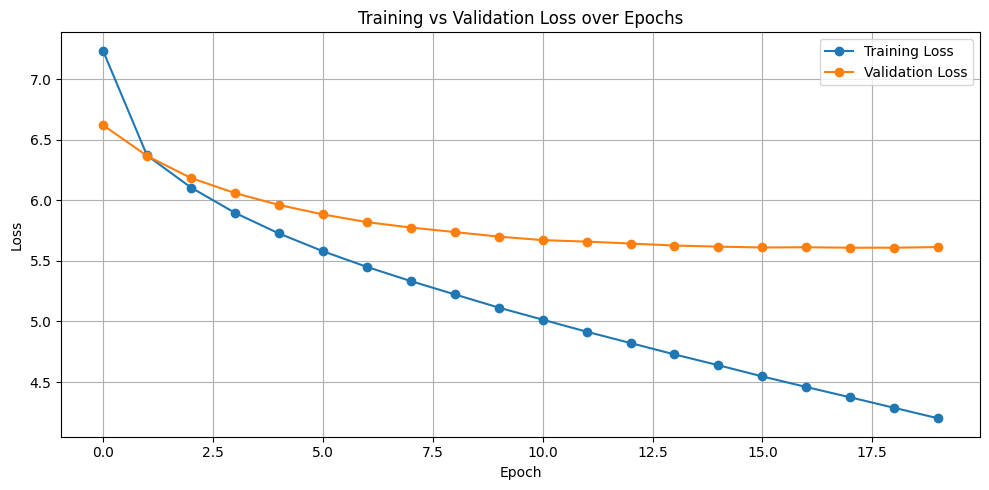

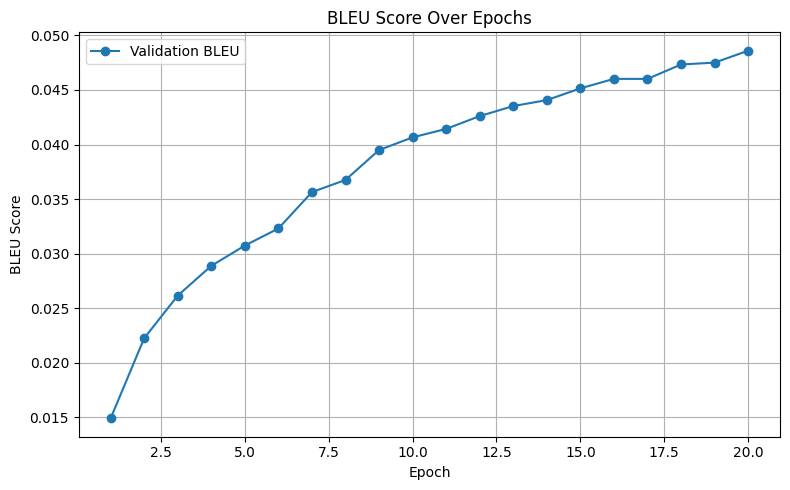

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), val_bleus, marker='o', label='Validation BLEU')
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#references:
# https://debuggercafe.com/language-translation-using-pytorch-transformer/, chatGPT